In [1]:
import numpy as np
import matplotlib.pyplot as plt

#System size
L = 4 #Hilbert space dimension is 2**L

#Constructing z-basis states
bin_set=[]
for i in range(2**L, 2**(L+1)):
    bin_set.append(bin(i)[3:])

pre_basis=[]
for binary in bin_set:
    pre_basis.append([int(digits) for digits in binary])
basis = np.ones_like(pre_basis)-np.array(pre_basis)

#0-theta, 0-phi eigenket generator
def eigenket(index):
    output = np.zeros(2**L).astype(complex)
    output[index] = 1
    return output
    
#Initial state
ground_zero = np.zeros(2**L)
ground_zero[0] = 1

#Test initial state
test = np.arange(2**L)

In [2]:
#Setting the permutation action of spin operators
def flipper(bin_seq,subspace):
    output = np.empty(len(bin_seq))
    output[:] = bin_seq[:] 
    if output[subspace] == 0:
        output[subspace] = 1
    else:
        output[subspace] = 0 
    return output.astype(int)

pre_flipped_assign = np.array([np.array([flipper(binary,sbspce) for binary in basis]) for sbspce in range(L)])
dec_converter = np.array([2**n for n in range(L)][::-1])
multiplied = dec_converter*pre_flipped_assign

#Cheat sheet for the sigma function
permutations = np.array([[2**L-1-np.sum(bin_arrays) for bin_arrays in multiplied[sbspce]] for sbspce in range(L)]).astype(int)
tracker = 2*(np.array(basis).transpose()-1/2) #Records the initial state of flipped state. "0" states are mapped to -1, "1 states are mapped to +1".

#Defining the spin operators
def sigma(vector,*xyz_subspace):
    global L, permutations, tracker
    
    input_vec = np.empty(2**L).astype(complex)
    input_vec[:] = vector[:]
    output = np.empty(2**L).astype(complex)
    
    
    for entry in xyz_subspace[::-1]:
        xyz = entry[0]
        subspace = entry[1]
        
        if subspace == L: #Imposing periodic boundary condition
            subspace = 0
        
        for i in range(2**L):
            if xyz == 1: #spin x
                output[permutations[subspace,i]] = input_vec[i]

            if xyz == 2: #spin y
                output[permutations[subspace,i]] = (1j*input_vec*tracker[subspace])[i]

            if xyz == 3: #spin z
                output[i] = (input_vec*tracker[subspace])[i]
        
        input_vec[:] = output[:]

    return output

#Constructing a function that adds sigma maps
def sigma_add(vector,*xyz_subspace_set):
    output = np.zeros(2**L).astype(complex)
    
    for xyz_subspace in xyz_subspace_set:
        output[:] += sigma(vector,*xyz_subspace)
        
    return output

In [3]:
#Constructing operators

#Defining the alpha function
def alpha_num(theta,phi,h,J):
    return h**2*(2*h**4*np.cos(theta)**6*np.cos(phi)+2*h**4*np.sin(theta)**6*np.cos(phi)**5+2*h**4*np.sin(theta)**2*np.cos(theta)**4*np.cos(phi)+2*h**4*np.sin(theta)**4*np.cos(theta)**2*np.cos(phi)**5+4*h**4*np.sin(theta)**2*np.cos(theta)**4*np.cos(phi)**3+4*h**4*np.sin(theta)**4*np.cos(theta)**2*np.cos(phi)**3+h**2*J**2*np.cos(theta)**4*np.cos(phi)+6*h**2*J**2*np.sin(theta)**4*np.cos(phi)**3+9*h**2*J**2*np.sin(theta)**2*np.cos(theta)**2*np.cos(phi)+7*h**2*J**2*np.sin(theta)**2*np.cos(theta)**2*np.cos(phi)**3+4*J**4*np.sin(theta)**2*np.cos(phi))
def alpha_denom(theta,phi,h,J):
    return 2*h**6*np.sin(theta)**6*np.cos(phi)**6+6*h**6*np.sin(theta)**4*np.cos(theta)**2*np.cos(phi)**4+6*h**6*np.sin(theta)**2*np.cos(theta)**4*np.cos(phi)**2+2*h**6*np.cos(theta)**6+6*h**4*J**2*np.sin(theta)**4*np.cos(phi)**4+30*h**4*J**2*np.sin(theta)**2*np.cos(theta)**2*np.cos(phi)**2-3*h**4*J**2*np.cos(theta)**4+12*h**2*J**4*np.sin(theta)**2*np.cos(phi)**2+14*h**2*J**4*np.cos(theta)**2+8*J**6
def alpha(theta,phi,h,J):
    numerator = alpha_num(theta,phi,h,J)
    if numerator==0:
        return 0
    else:
        return numerator/alpha_denom(theta,phi,h,J)

#Defining the beta funnction
def beta_num(theta,phi,h,J):
    return h**3*J*(4*h**2*np.sin(theta)**5*np.cos(phi)**4-5*h**2*np.sin(theta)**3*np.cos(theta)**2*np.cos(phi)**2+7*h**2*np.sin(theta)**3*np.cos(theta)**2*np.cos(phi)**4-2*h**2*np.sin(theta)*np.cos(theta)**4*np.cos(phi)**2+4*J**2*np.sin(theta)**3*np.cos(phi)**2+6*J**2*np.sin(theta)*np.cos(theta)**2*np.cos(phi)**2)
def beta_denom(theta,phi,h,J): 
    return 2*(2*h**6*np.sin(theta)**6*np.cos(phi)**6+6*h**6*np.sin(theta)**4*np.cos(theta)**2*np.cos(phi)**4+6*h**6*np.sin(theta)**2*np.cos(theta)**4*np.cos(phi)**2+2*h**6*np.cos(theta)**6+6*h**4*J**2*np.sin(theta)**4*np.cos(phi)**4+30*h**4*J**2*np.sin(theta)**2*np.cos(theta)**2*np.cos(phi)**2-3*h**4*J**2*np.cos(theta)**4+12*h**2*J**4*np.sin(theta)**2*np.cos(phi)**2+14*h**2*J**4*np.cos(theta)**2+8*J**6)
def beta(theta,phi,h,J):
    numerator = beta_num(theta,phi,h,J)
    if numerator==0:
        return 0
    else:
        return numerator/beta_denom(theta,phi,h,J)

#Defining the gamma function
def gamma_num(theta,phi,h,J):
    return -(512*h**9*J**2*np.cos(theta)**10*np.cos(phi)+1024*h**9*J**2*np.sin(theta)**2*np.cos(theta)**8*np.cos(phi)-2*h**9*J**2*np.sin(theta)**8*np.cos(theta)**2*np.cos(phi)**9-896*h**9*J**2*np.sin(theta)**2*np.cos(theta)**8*np.cos(phi)**3+20*h**9*J**2*np.sin(theta)**6*np.cos(theta)**4*np.cos(phi)**5-2*h**9*J**2*np.sin(theta)**8*np.cos(theta)**2*np.cos(phi)**5+72*h**9*J**2*np.sin(theta)**4*np.cos(theta)**6*np.cos(phi)**5-384*h**9*J**2*np.sin(theta)**4*np.cos(theta)**6*np.cos(phi)**3+48*h**9*J**2*np.sin(theta)**6*np.cos(theta)**4*np.cos(phi)**5-256*h**7*J**4*np.cos(theta)**8*np.cos(phi)+1536*h**7*J**4*np.sin(theta)**2*np.cos(theta)**6*np.cos(phi)+12*h**7*J**4*np.sin(theta)**6*np.cos(theta)**2*np.cos(phi)**5-896*h**7*J**4*np.sin(theta)**2*np.cos(theta)**6*np.cos(phi)**3+20*h**7*J**4*np.sin(theta)**4*np.cos(theta)**4*np.cos(phi)**5+24*h**7*J**4*np.sin(theta)**6*np.cos(theta)**2*np.cos(phi)**5-384*h**7*J**4*np.sin(theta)**4*np.cos(theta)**4*np.cos(phi)**3-1152*h**5*J**6*np.cos(theta)**6*np.cos(phi)+768*h**5*J**6*np.sin(theta)**2*np.cos(theta)**4*np.cos(phi)-8*h**5*J**6*np.sin(theta)**4*np.cos(theta)**2*np.cos(phi)**5-224*h**5*J**6*np.sin(theta)**2*np.cos(theta)**4*np.cos(phi)**3-96*h**5*J**6*np.sin(theta)**4*np.cos(theta)**2*np.cos(phi)**3-704*h**3*J**8*np.cos(theta)**4*np.cos(phi)+128*h**3*J**8*np.sin(theta)**2*np.cos(theta)**2*np.cos(phi)-128*h*J**10*np.cos(theta)**2*np.cos(phi))
def gamma_denom(theta,phi,h,J):
    return 4*J*np.cos(theta)*(-h**2*np.sin(theta)**2*np.cos(phi)**2+8*h**2*np.cos(theta)**2+4*J**2)**2*(2*h**6*np.sin(theta)**6*np.cos(phi)**6+6*h**6*np.sin(theta)**4*np.cos(theta)**2*np.cos(phi)**4+6*h**6*np.sin(theta)**2*np.cos(theta)**4*np.cos(phi)**2+2*h**6*np.cos(theta)**6+6*h**4*J**2*np.sin(theta)**4*np.cos(phi)**4+30*h**4*J**2*np.sin(theta)**2*np.cos(theta)**2*np.cos(phi)**2-3*h**4*J**2*np.cos(theta)**4+12*h**2*J**4*np.sin(theta)**2*np.cos(phi)**2+14*h**2*J**4*np.cos(theta)**2+8*J**6)
def gamma(theta,phi,h,J):
    numerator = gamma_num(theta,phi,h,J)
    if numerator==0:
        return 0
    else:
        return numerator/gamma_denom(theta,phi,h,J)
    
#Operators coupled with the alpha, beta, and gamma functions
alpha_map_entries = [[[2,i]] for i in range(L)]
beta_map_entries = [[[1,i],[2,i+1]] for i in range(L)]+[[[2,i],[1,i+1]] for i in range(L)]
gamma_map_entries = [[[3,i],[2,i+1]] for i in range(L)]+[[[2,i],[3,i+1]] for i in range(L)]

def alpha_map(vector):
    return sigma_add(vector,*alpha_map_entries)
def beta_map(vector):
    return sigma_add(vector,*beta_map_entries)
def gamma_map(vector):
    return sigma_add(vector,*gamma_map_entries)

#Constructing the theta gauge potential
def gauge_theta(vector,theta,phi,h,J):
    return (1/2)*(alpha(theta,phi,h,J)*alpha_map(vector)+beta(theta,phi,h,J)*beta_map(vector)+gamma(theta,phi,h,J)*gamma_map(vector))

#Constructing theta unitary operators
def unitary_dtheta(vector,dtheta,theta0,phi0,h,J):
    return vector - 1j*dtheta*gauge_theta(vector,theta0,phi0,h,J)

def propagator_theta(vector,dtheta,steps,theta_init,phi,h,J):
    output = np.empty([steps+1,2**L]).astype(complex)
    output[0,:] = vector[:]
    
    state = np.empty(2**L).astype(complex)
    state[:] = vector[:]
    theta0 = theta_init
    
    for i in range(1,steps+1):
        output[i,:] = unitary_dtheta(state,dtheta,theta0,phi,h,J)[:]
        state[:] = output[i,:]
        theta0 += dtheta

    return output

#Constructing operators for the phi parameter
gauge_phi_entries = [[[3,i]] for i in range(L)]

def gauge_phi(vector):
    return (1/2)*sigma_add(vector,*gauge_phi_entries)

def unitary_phi(vector,phi):
    output = np.empty(2**L).astype(complex)
    output[:] = vector[:] 
    
    for i in range(L):
        output = np.cos(phi/2)*output - 1j*np.sin(phi/2)*sigma(output,[3,i])
    
    return output

In [18]:
#Calculating instantaneous ground states
h = 2
J = 1

#Setting theta data points
theta_start = 0
theta_end = np.pi
theta_data_points = 1001 #Not including theta_start (total data points will be *_data_points + 1)
interval_theta = abs(theta_end-theta_start)/theta_data_points

theta_vals = np.linspace(theta_start,theta_end,theta_data_points+1)

#Setting phi data points
phi_start = 0
phi_end = 2*np.pi
phi_data_points = 100 #Not including phi_start (total data points will be *_data_points + 1)
interval_phi = abs(phi_end-phi_start)/phi_data_points

phi_vals = np.linspace(phi_start,phi_end,phi_data_points+1)

#Preparing instantaneous ground states (nesting order is phi set then theta set: [phi,theta])
ground_kets = np.array([[unitary_phi(state,phi) for state in propagator_theta(ground_zero,interval_theta,theta_data_points,theta_start,0,h,J)] for phi in phi_vals])

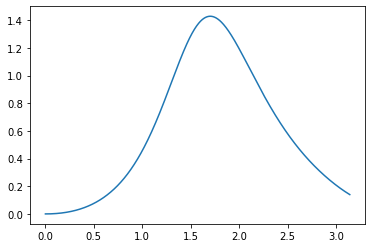

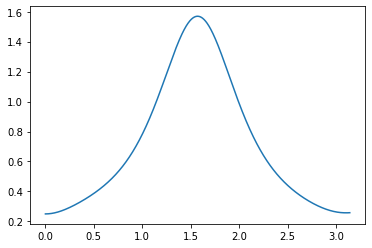

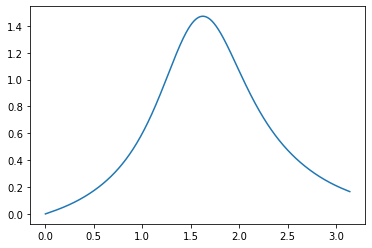

In [19]:
#Calculating g_{phi,phi} data points
#Nesting order is still [phi,theta].
pre_g_phi_phi_term1 = np.array([[gauge_phi(ground_kets[i,j]) for j in range(len(theta_vals))] for i in range(len(phi_vals))])
g_phi_phi_term1 = np.real(np.array([[np.vdot(pre_g_phi_phi_term1[i,j],pre_g_phi_phi_term1[i,j]) for j in range(len(theta_vals))] for i in range(len(phi_vals))]))
g_phi_phi_term2 = np.real(np.array([[np.vdot(ground_kets[i,j],pre_g_phi_phi_term1[i,j])**2 for j in range(len(theta_vals))] for i in range(len(phi_vals))]))
g_phi_phi_vals = g_phi_phi_term1 - g_phi_phi_term2

#Calculating g_{theta,theta} data points
#Nesting order is still [phi,theta].
pre_g_theta_theta_term1 = np.array([[gauge_theta(ground_kets[i,j],theta_vals[j],phi_vals[i],h,J) for j in range(len(theta_vals))] for i in range(len(phi_vals))])
#difference of putting phi_vals[i] in gauge_theta(...)
g_theta_theta_term1 = np.real(np.array([[np.vdot(pre_g_theta_theta_term1[i,j],pre_g_theta_theta_term1[i,j]) for j in range(len(theta_vals))] for i in range(len(phi_vals))]))
g_theta_theta_term2 = np.real(np.array([[np.vdot(ground_kets[i,j],pre_g_theta_theta_term1[i,j])**2 for j in range(len(theta_vals))] for i in range(len(phi_vals))]))
g_theta_theta_vals = g_theta_theta_term1 - g_theta_theta_term2

#Calculating the Berry curvature
x_theta_phi_term1 = np.imag(np.array([[np.vdot(pre_g_theta_theta_term1[i,j],pre_g_phi_phi_term1[i,j]) for j in range(len(theta_vals))] for i in range(len(phi_vals))]))
expectation_gauge_theta = np.real(np.array([[np.vdot(ground_kets[i,j],pre_g_theta_theta_term1[i,j]) for j in range(len(theta_vals))] for i in range(len(phi_vals))]))
expectation_gauge_phi = np.real(np.array([[np.vdot(ground_kets[i,j],pre_g_phi_phi_term1[i,j]) for j in range(len(theta_vals))] for i in range(len(phi_vals))]))
x_theta_phi_term2 = expectation_gauge_theta*expectation_gauge_phi
x_theta_phi_vals = x_theta_phi_term1 - x_theta_phi_term2

Verification tools

Showing plots at phi = 1.5*pi.
g_[phi,phi] vs. theta


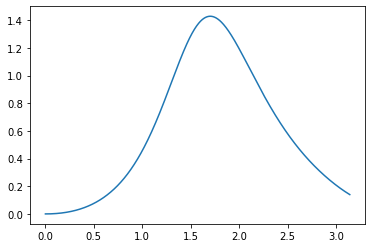

g_[theta,theta] vs. theta


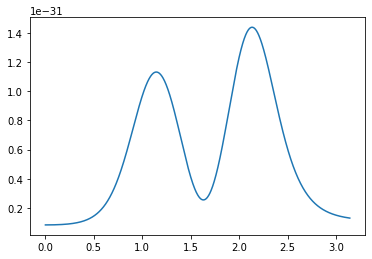

g_[theta,phi] vs. theta


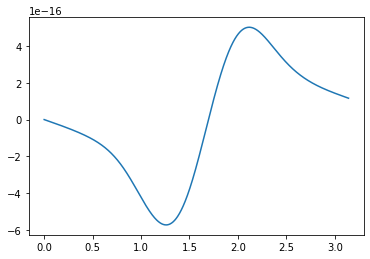

In [40]:
#Plotting

#Change index to see plots at different phi value
phi_val_index = 75
print(f"Showing plots at phi = {phi_vals[phi_val_index]/np.pi}*pi.")

#g_{phi,phi}
print("g_[phi,phi] vs. theta")
plt.plot(theta_vals,g_phi_phi_vals[phi_val_index])
plt.show()

#g_{theta,theta}
print("g_[theta,theta] vs. theta")
plt.plot(theta_vals,g_theta_theta_vals[phi_val_index])
plt.show()

#g_{theta,phi}
print("g_[theta,phi] vs. theta")
plt.plot(theta_vals,x_theta_phi_vals[phi_val_index])
plt.show()

In [436]:
#Defining the Hamiltonian and seeking the ground state
h_map_x_entries = [[[1,i]] for i in range(L)]
h_map_y_entries = [[[2,i]] for i in range(L)]
h_map_z_entries = [[[3,i]] for i in range(L)]
J_map_entries = [[[3,i],[3,i+1]] for i in range(L)]

def h_map_x(vector):
    return sigma_add(vector,*h_map_x_entries)
def h_map_y(vector):
    return sigma_add(vector,*h_map_y_entries)
def h_map_z(vector):
    return sigma_add(vector,*h_map_z_entries)
def J_map(vector):
    return sigma_add(vector,*J_map_entries)

def hamiltonian(vector,theta,phi,h,J):
    return -h*(np.cos(theta)*h_map_z(vector)+np.sin(theta)*np.sin(phi)*h_map_y(vector)+np.sin(theta)*np.cos(phi)*h_map_x(vector)) - J*J_map(vector)

def eigenket(index):
    output = np.zeros(2**L)
    output[index] = 1 
    return output

#eigenvalues = np.array([np.real(np.vdot(eigenket(i),hamiltonian(eigenket(i),0,np.pi/2,1,2))) for i in range(2**L)])

def ground_seeker(array):
    output = []
    minimum = np.amin(array)
    
    for i in range(len(array)):
        if array[i] == minimum:
            output.append(i)
            
    return output

In [402]:
theta = np.pi/2
phi = 0.52359878

ham_matrix = np.array([[np.vdot(eigenket(i),hamiltonian(eigenket(j),theta,phi,h,J)) for j in range(2**L)] for i in range(2**L)])
# print(np.real(ham_matrix))
solution = np.linalg.eig(ham_matrix)
eigenvalues = np.real(solution[0])
min_val = np.min(eigenvalues)
min_index = np.argmin(eigenvalues)
print(eigenvalues,", index of minimum: ",min_index)
normalized_ground = solution[1].transpose()[min_index]
# normalized_ground = lowest/np.sqrt(np.real(np.vdot(lowest,lowest)))
candidate = ground_kets[1,int(theta_data_points/2)]

[-1.  1.] , index of minimum:  0


In [403]:
print(hamiltonian(candidate,theta,phi,h,J))
print(candidate*min_val)

[-0.68343371+0.18312551j -0.68343459-0.18312575j]
[-0.68343459+0.18312575j -0.68343371-0.18312551j]


In [405]:
print(hamiltonian(normalized_ground,theta,phi,h,J))
print(normalized_ground*min_val)

[-0.61237243+3.53553393e-01j -0.70710678+5.55111512e-17j]
[-0.61237243+0.35355339j -0.70710678+0.j        ]


These sanity checks give a positive result (sane). But, at best we just know that the gauge potentials we used here are Hermitian, and not if they are the correct gauge potentials. I am pretty confident the theta gauge potential is correct. I'll check if the phi gauge potential is indeed what the reference claims it to be.